In [1]:
from scipy import signal
import matplotlib.pyplot as plt
from Utils import *
import numpy as np
import h5py

# Load Data and Prepare STFT.
dn = np.load('Example_Data.npy')
dn =  butter_bandpass_filter_zi(dn, 1, 45, 100, order=10)
fs = 100
le = 20
leov = int(le/2)
f, t, Zxx = signal.stft(dn, fs=100, window='hann', nperseg=le, noverlap=leov, nfft=2*le, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)
dnPatchR = np.real(Zxx)
dnPatchI = np.imag(Zxx)
dnPatchA = np.abs(Zxx)
if np.max(dnPatchA)>1:
    maA = np.max(np.abs(dnPatchA)) 
    maR = np.max(np.abs(dnPatchR)) 
    maI = np.max(np.abs(dnPatchI)) 
    dnPatchR = dnPatchR/np.max(np.abs(dnPatchR))
    dnPatchI = dnPatchI/np.max(np.abs(dnPatchI))
    dnPatchA = dnPatchA/np.max(np.abs(dnPatchA))



Using TensorFlow backend.
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\owner\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Patching 
w1 =8
w2 =8
s1z =1
s2z =1
dn_patchA = yc_patch(dnPatchA,w1,w2,s1z,s2z)
dn_patchR = yc_patch(dnPatchR,w1,w2,s1z,s2z)
dn_patchI = yc_patch(dnPatchI,w1,w2,s1z,s2z)


In [3]:
# Proposed DL Network.
from keras.layers import Input, Dense, Dropout, Add, multiply, GlobalAvgPool1D, Reshape, concatenate, UpSampling1D, Flatten, MaxPooling1D, BatchNormalization, average, Conv1D
from keras.models import Model
import scipy.io
from keras import optimizers
from keras.callbacks import EarlyStopping
import h5py
from math import*
import numpy as np
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import backend as K
import tensorflow as tf

import oct2py
import numpy as np
import h5py
oc = oct2py.Oct2Py()



corr1=0
corr2=1
corr3=1
#dataNoise = np.load(r'E:\1DDenoising/dn_patch_SCALO.npy')
dataNoiseR = dn_patchR
dataNoiseI = dn_patchI
dataNoiseA = dn_patchA

print(np.shape(dataNoiseR))

# Random Permute for the patches for training
#ind = np.random.permutation(len(dataNoise))
#dataNoise = np.array(dataNoise)
#dataNoise = dataNoise[ind]

# Orders.
D1 = 32
D2 = int(D1/2)
D3 = int(D2/2)
D4 = int(D3/2)
D5 = int(D4/2)
D6 = int(D5/2)

# Real and Imaginary Inputs.
INPUT_SIZE1 = dataNoiseR.shape[0]
INPUT_SIZE2 = dataNoiseI.shape[1]
#ENCODING_SIZE = 16
 
input_img1 = Input(shape=(INPUT_SIZE2,))
input_img2 = Input(shape=(INPUT_SIZE2,))

######### Encoder ###########
input_img1x = Reshape((input_img1._keras_shape[-1],1))(input_img1)
input_img2x = Reshape((input_img2._keras_shape[-1],1))(input_img2)


input_img3 = concatenate([input_img1x,input_img2x])
# Encoder
e1 = compactlayer(input_img3,D1)
e2 = compactlayer(e1,D2)
e3 = compactlayer(e2,D3)
# Decoder
d4 = compactlayer(e3,D2)
d4 = Add()([d4,e2])
d5 = compactlayer(d4,D1)
d5 = Add()([d5,e1])
d6 = compactlayer(d5,D1)


d6 = Flatten()(d6)    
outA = Dense(INPUT_SIZE2, activation='softplus')(d6)



# Customize Loss Function.
def MASK_LOSS(y_true, y_pred):
    
    nois = y_true - y_pred
    maskbiS =  1 / (1 + (K.abs(nois)/K.abs(y_pred)))
    maskbiN = (K.abs(nois)/K.abs(y_pred)) / (1+(K.abs(nois)/K.abs(y_pred)))
    
    #return   K.abs(1-maskbiS) + K.abs(maskbiN)   
    return   K.abs(1-maskbiS) 

            
autoencoder = Model([input_img1,input_img2], [outA])
sgd = optimizers.adam(lr=0.0001)
autoencoder.compile(optimizer=sgd, loss=[MASK_LOSS])    



autoencoder.summary()

# Addig stopping condition
es=EarlyStopping(monitor='loss',mode='min',verbose=1,patience=5)
mc=ModelCheckpoint('best_model_STFT_STEAD_Real_10.h5',monitor='loss',mode='min',save_best_only=True)


batch = int(np.ceil(len(dataNoiseR)*0.005))
#batch = 128
print('Batch Size is:' + str(batch))
tic()
history = autoencoder.fit([dataNoiseR,dataNoiseI],[dataNoiseA], epochs=50, batch_size=batch, shuffle=False,callbacks=[es,mc],verbose=0)
toc()



(4116, 64)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64)           0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 64, 1)        0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 64, 1)        0           input_2[0][0]                    
_________________________________________________________________________________


Elapsed time is 74.76904773712158 seconds.


In [4]:
# Predict
from keras.models import load_model

batch = batch

model = load_model('best_model_STFT_STEAD_Real_10.h5', custom_objects={"MASK_LOSS":MASK_LOSS})
print('Loaded Best Model')

tic()
xA = model.predict([dataNoiseR,dataNoiseI],batch_size=batch)
toc()


Loaded Best Model
Elapsed time is 0.958437442779541 seconds.


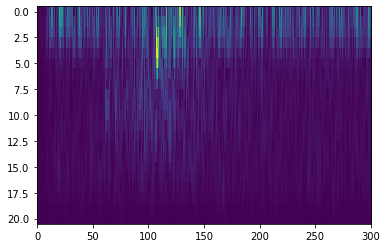

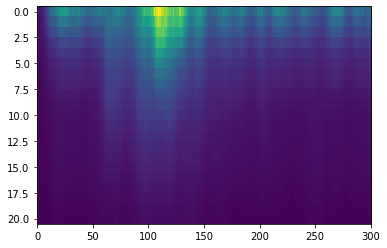

In [5]:
# Unpatching
X1 = np.transpose(xA)
n1,n2=np.shape(dnPatchA)
outA = yc_patch_inv(X1,n1,n2,w1,w2,s1z,s2z)
outA = np.array(outA)

#Plot Input Target and Predicted Mask.
plt.imshow(dnPatchA, aspect='auto')
plt.figure()
plt.imshow(outA, aspect='auto')

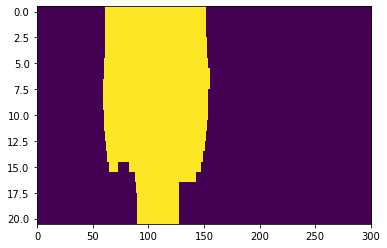

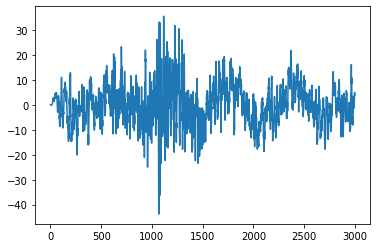

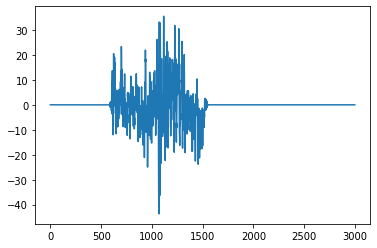

In [7]:
# Thresholding 

dn = np.load('Example_Data.npy')
f, t, Zxxdn = signal.stft(dn, fs=100, window='hann', nperseg=le, noverlap=leov, nfft=2*le, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)
ZxxdnR = np.real(Zxxdn)
ZxxdnI = np.imag(Zxxdn)



yy = 1
sizmedian = 15
outAM = (outA*maA)
outAM = outAM/np.max(np.abs(outAM))

for iu in range(outAM.shape[0]):
    tmp = np.copy(outAM[iu,:])
    #tmp[tmp>=1*np.mean(tmp)]=1
    tmp[tmp<1*np.mean(tmp)]=1e-10
    outAM[iu,:] = tmp


mea = np.mean(outAM)
outAM[outAM>=yy*mea]=1
outAM[outAM<yy*mea]=1e-10
outAM = ndimage.median_filter(outAM, size=sizmedian)

dn_mask = np.real(Zxxdn)*outAM + 1j*np.imag(Zxxdn)*outAM

rec = signal.istft(dn_mask,  fs=100, window='hann', nperseg=le, noverlap=leov, nfft=2*le, boundary='zeros')
rec = np.array(rec)

# Plot Mask, Input, and Output.
plt.imshow(outAM, aspect='auto')
plt.figure()
plt.plot(dn)
plt.figure()
plt.plot(rec[1,:])

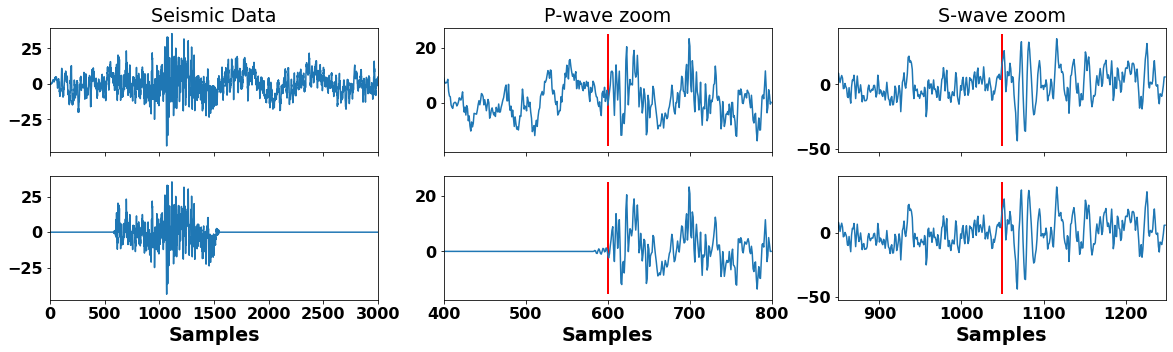

In [9]:
P = np.load('Example_Data_P.npy')
S = np.load('Example_Data_S.npy')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

x = np.arange(len(dn))
fig = plt.figure(figsize=(20,5))
ax1 = plt.subplot(2,3,1)
plt.plot(x,dn)
plt.title('Seismic Data')
plt.xlim([0,3000])
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(2,3,2)
plt.plot(x[P-200:P+200],dn[P-200:P+200])
ymin, ymax = plt.ylim()
plt.vlines(P, ymin, ymax, color='r', linewidth=2)
plt.title('P-wave zoom')
plt.xlim([P-200,P+200])
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(2,3,3)
plt.plot(x[S-200:S+200], dn[S-200:S+200])
ymin, ymax = plt.ylim()
plt.vlines(S, ymin, ymax, color='r', linewidth=2)
plt.title('S-wave zoom')
plt.xlim([S-200,S+200])
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = plt.subplot(2,3,4, sharex=ax1)
plt.plot(rec[1,:])
plt.xlabel('Samples',fontsize='large', fontweight='bold')
plt.xlim([0,3000])

ax5 = plt.subplot(2,3,5, sharex=ax2)
plt.plot(x[P-200:P+200],rec[1,P-200:P+200])
ymin, ymax = plt.ylim()
plt.vlines(P, ymin, ymax, color='r', linewidth=2)
plt.xlabel('Samples',fontsize='large', fontweight='bold')
plt.xlim([P-200,P+200])

ax6 = plt.subplot(2,3,6, sharex=ax3)
plt.plot(x[S-200:S+200],rec[1,S-200:S+200])
ymin, ymax = plt.ylim()
plt.vlines(S, ymin, ymax, color='r', linewidth=2)
plt.xlabel('Samples',fontsize='large', fontweight='bold')
plt.xlim([S-200,S+200])
plt.show()